## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.groupby('converted')['user_id'].nunique()/df['user_id'].nunique()


converted
0    0.881931
1    0.121042
Name: user_id, dtype: float64

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:

df[((df['group'] == 'treatment') == (
    df['landing_page'] == 'new_page')) == False].shape[0]


3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.copy()
df2=df2[((df2['group']=='treatment')==(df2['landing_page']=='new_page'))!=False]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id.iloc[0]


773192

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(2893,inplace=True)


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
conv_mean=df2.converted.mean()
print(f'the probability of  converting is {conv_mean} ')


the probability of  converting is 0.11959708724499628 


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_conv=df[df['group']=='control']['converted'].mean()
print(f' the probability of control group the conerted  {control_conv}')

 the probability of control group the conerted  0.12039917935897611


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_conv = df[df['group'] == 'treatment']['converted'].mean()
print(f' the probability of treatment group the conerted  {treatment_conv}')


 the probability of treatment group the conerted  0.11891957956489856


d. What is the probability that an individual received the new page?

In [17]:
new_page_conv = (df['landing_page'] == 'new_page').mean()
print(f' the probability of treatment group the conerted  {new_page_conv}')


 the probability of treatment group the conerted  0.5


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> I don't think so, because there's not enough evidence to say that the new treatment page leads to more conversion.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new=conv_mean
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old=conv_mean
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new=df2[df2['landing_page']=='new_page'].count()[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old=df2[df2['landing_page']=='old_page'].count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted=np.random.choice([0,1],size=n_new,p=((1-p_new),p_new))
new_page_converted.mean()

0.11958571330259446

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=((1-p_old), p_old))
old_page_converted.mean()


0.11942949185676721

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()


0.00015622144582724817

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs=[]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=n_new,p=((1-p_new),p_new))
    old_page_converted = np.random.choice([0, 1], size=n_old, p=((1-p_old), p_old))
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 0, ' difference of probablility')

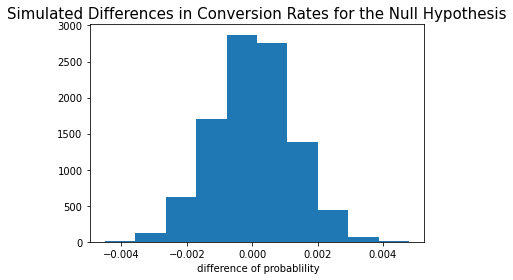

In [26]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.title(
    "Simulated Differences in Conversion Rates for the Null Hypothesis", fontsize=15)
plt.xlabel(' difference of probablility')


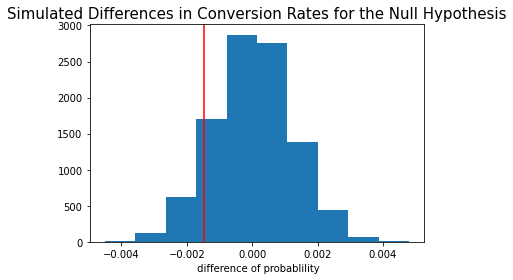

In [27]:
obs_diff = treatment_conv - control_conv
plt.hist(p_diffs)
plt.title(
    "Simulated Differences in Conversion Rates for the Null Hypothesis", fontsize=15)
plt.xlabel(' difference of probablility')
plt.axvline(x=obs_diff,c='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs>=obs_diff).mean()

0.8931

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> In this penalty, we calculated p_value in order to reject his null hypothesis, in order to reject the null hypothesis, his division must be p_value less than 0.05. (Agreed level of 5% chance to make Type 1 error if dissolution is correct) In our case, we found that the calculated p value is estimated to be 0.895 above that we can reject the null hypothesis to your end, there is insufficient evidence to say that there is a difference in conversion between new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old =df2.query('group=="control" and converted==1')['converted'].count()
convert_new = df2.query('group=="treatment" and converted==1')[
    'converted'].count()
n_old = n_new = df2[df2['landing_page'] == 'old_page'].count()[0]
n_new = df2[df2['landing_page'] == 'new_page'].count()[0]
print(f'convert_new : {convert_new}')
print(f'convert_old : {convert_old}')
print(f'n_new : {n_new}')
print(f'n_old : {n_old}')


convert_new : 17264
convert_old : 17489
n_new : 145310
n_old : 145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest(
    [convert_new, convert_old], [n_new, n_old], alternative='larger')

print(f'z_score : {z_score}')
print(f'p_value : {p_value}')


z_score : -1.3109241984234394
p_value : 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

A z-score is the number of standard deviations from the mean a data point is (obs_diff). The z-score and p-value computed in the previous question agree with the findings in parts j. and k (p-value == 0.9).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>  Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept']=1
df2[['ab_page','old_page']]=pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
result.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-07 18:44 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> the p_value here is 0.1899     
                                                                                           
> This is because the Logit Regression is based on a two-tailed test.   
                                                              
> 0.1899 is great than 0.05 so  we still can't reject the null hypotheses  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>  It might be a good idea to add some attributes like nationality, age or behavior so that you can get more information about them.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [35]:
### chack for count of country
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [36]:
### Create the necessary dummy variables
df_new[['us','uk','ca']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,us,uk,ca
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [37]:
lm2=sm.Logit(df_new['converted'],df_new[['intercept','us','uk']])
result2=lm2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-10-07 18:44 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
us           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
uk            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

> p_value stall great that 0.05 so we  still can't reject null hypotheses  

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
df_new['uk_page']=df_new['uk']*df_new['ab_page']
df_new['us_page']=df_new['us']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,us,uk,ca,uk_page,us_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [39]:
### Fit Your Linear Model And Obtain the Results
lm3=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','uk','us','uk_page','us_page']])
result3=lm3.fit()
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-07 18:44 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
uk           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
us           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
uk_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
us_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

>  p-values for all variables (all higher than 0.05).

<a id='conclusions'></a>
## Conclusions

> general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.

## Resources
 - https://pandas.pydata.org/docs/user_guide/index.html#user-guide
 -https://numpy.org/doc/stable/user/index.html#user
 -https://www.statsmodels.org/devel/gettingstarted.html

